# Lab 2 Transfer Learning Model

Ziyuan Tang

In [1]:
from PIL import Image
from tensorflow.keras.datasets import cifar10
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,Input, AveragePooling2D, Activation,Conv2D, MaxPooling2D, BatchNormalization,Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.math import confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import glob,os


## 1. Confusion Matrix Plot Function

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


## 2. Define Models

### 2.1 Import Old Model

In [3]:
import keras
model=keras.models.load_model('model.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)       

### 2.1 Build New Model

Transfer weight of 1-7 layers to new model with unfreezed weight and freezed weight

In [4]:
## build all 14 tf models
layer_index=[19,14,12,8,6,2,0]
layer_func = [Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
             BatchNormalization(),Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
             BatchNormalization(),MaxPool2D((2, 2)),Dropout(0.2),Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
             BatchNormalization(),Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),BatchNormalization(),
             MaxPool2D((2, 2)),Dropout(0.3),Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
             BatchNormalization(),Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
             BatchNormalization(),MaxPool2D((2, 2)),Dropout(0.4),Flatten(),Dense(128, activation='relu', kernel_initializer='he_uniform'),
             BatchNormalization(),Dropout(0.5),Dense(11, activation='softmax')]

model_tf_unfreezed =[]
model_tf_freezed = []

for i in layer_index:
    model=keras.models.load_model('model.h5')
    model_new = keras.Model(inputs=model.input, outputs=model.layers[i].output)

    model_new_unfreezed = keras.Sequential()
    model_new_unfreezed.add(model_new)
    for j in range(i+1,len(layer_func)):
        model_new_unfreezed.add(layer_func[j]) 
        
    model=keras.models.load_model('model.h5')
    model_new = keras.Model(inputs=model.input, outputs=model.layers[i].output) 
    model_new_freezed = keras.Sequential()
    model_new_freezed.add(model_new)
    model_new_freezed.layers[0].trainable = False
    for j in range(i+1,len(layer_func)):
        model_new_freezed.add(layer_func[j]) 
        
    model_tf_unfreezed.append(model_new_unfreezed)
    model_tf_freezed.append(model_new_freezed)
    if i==19:
        print(model_new.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24_input (InputLayer) [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 32)        0   

In [5]:

for index, layer in enumerate(model_tf_freezed[0].layers):
    print("Layer: {}, Trainable: {}".format(index, layer.trainable))
    
model_tf_freezed[0].summary()

Layer: 0, Trainable: False
Layer: 1, Trainable: True
Layer: 2, Trainable: True
Layer: 3, Trainable: True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 128)               551072    
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1419      
Total params: 553,003
Trainable params: 1,675
Non-trainable params: 551,328
_________________________________________________________________


## 3. Load and Preprocessing Data

In [6]:
(x_train, y_train), (x_test, y_test)=cifar10.load_data()
instances = []
images_path='converted-agumented'
# Load in the images
for filepath in os.listdir(images_path):  
    image=( Image.open(images_path+"/"+filepath))
    data=np.asarray(image)
    if data.shape!=(32,32,3): 
        print(filepath)
        continue
    instances.append(data)

bobcats=np.stack(instances, axis=0)
print(bobcats.shape)
bobcat_group=np.arange(6000).reshape(6000,1); 
bobcat_group.fill(10)
print(bobcat_group  .shape)
x_train=np.concatenate((x_train,bobcats[:5000,:,:,:]),axis=0)
x_test=np.concatenate((x_test,bobcats[5000:,:,:,:]),axis=0)
y_train=np.concatenate((y_train,bobcat_group[:5000]),axis=0)
y_test=np.concatenate((y_test,bobcat_group[5000:]),axis=0)


print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of x_test is {}'.format(x_test.shape))
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_test is {}'.format(y_test.shape))


a= to_categorical(y_train)

print('Shape of y_train after to_categorical is {}'.format(a.shape))
# Normalizing
x_train=x_train/255
x_test=x_test/255

#One hot encoding
y_train_cat=to_categorical(y_train,11)
y_test_cat=to_categorical(y_test,11)

print(y_train_cat.shape)
print(y_test_cat.shape)






(6000, 32, 32, 3)
(6000, 1)
Shape of x_train is (55000, 32, 32, 3)
Shape of x_test is (11000, 32, 32, 3)
Shape of y_train is (55000, 1)
Shape of y_test is (11000, 1)
Shape of y_train after to_categorical is (55000, 11)
(55000, 11)
(11000, 11)


## 4. Train Models

In [19]:
## Freezed
history_freezed =[]
opt = SGD(learning_rate=0.001, momentum=0.9)
a= 7

for i in model_tf_freezed:
    i.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit_generator(train_generator,epochs=200,steps_per_epoch=training_steps,validation_data=test_generator,validation_steps=validation_steps,callbacks=[board])
    i = i.fit(x_train,y_train_cat,epochs=50,validation_data=(x_test,y_test_cat), verbose=0)

    print(str(a)+" layers model done")
    p_test = i.predict(x_test).argmax(axis=1)
    cm = confusion_matrix(y_test, p_test)
    plt.figure(figsize=(8, 6), dpi=80)
    plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True,title='Confusion matrix with freezed '+str(a)+" layers")
    a =a -1
    i.save('freezed_'+str(a)+'.h5')
        
    evaluation = i.evaluate(x_test, y_test_cat)
    print('Test Accuracy: {}'.format(evaluation[1]))
# save model
# for i in range(len(model_tf_freezed)):
#     model_tf_freezed[i].save('freezed_'+str(i)+'.h5')

SyntaxError: invalid syntax (<ipython-input-19-4eba365a7b7d>, line 6)

In [32]:

## Unfreezed
history_unfreezed =[]
lrs = 0.001
a= 7

for i in model_tf_unfreezed:
    opt = SGD(lr=lrs, momentum=0.9)
    i.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit_generator(train_generator,epochs=200,steps_per_epoch=training_steps,validation_data=test_generator,validation_steps=validation_steps,callbacks=[board])
    i.fit(x_train,y_train_cat,epochs=50,validation_data=(x_test,y_test_cat))
    print(str(a)+" layers model done")
    p_test = i.predict(x_test).argmax(axis=1)
    cm = confusion_matrix(y_test, p_test)
    plt.figure(figsize=(8, 6), dpi=80)
    plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True,title='Confusion matrix with freezed '+str(a)+" layers")
    a =a -1
    i.save('unfreezed_'+str(a)+'.h5')
        
    evaluation = i.evaluate(x_test, y_test_cat)
    print('Test Accuracy: {}'.format(evaluation[1]))



C:\Users\15047\anaconda3\envs\ensf511\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
  15/1719 [..............................] - ETA: 2:03 - loss: 0.1773 - accuracy: 0.9438

KeyboardInterrupt: 

## 5. Confusion Matrix

### 5.1 Freezed Layer

Normalized confusion matrix


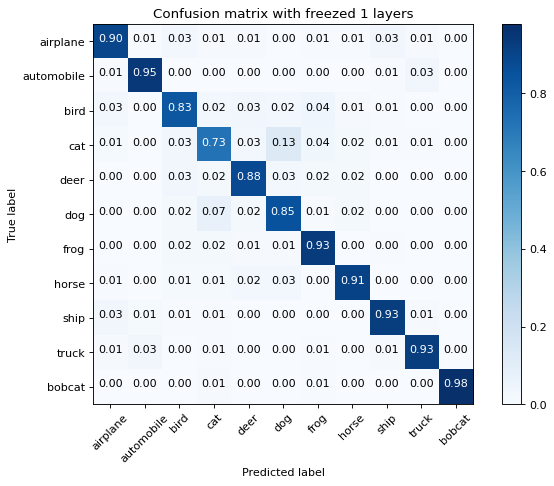

Normalized confusion matrix


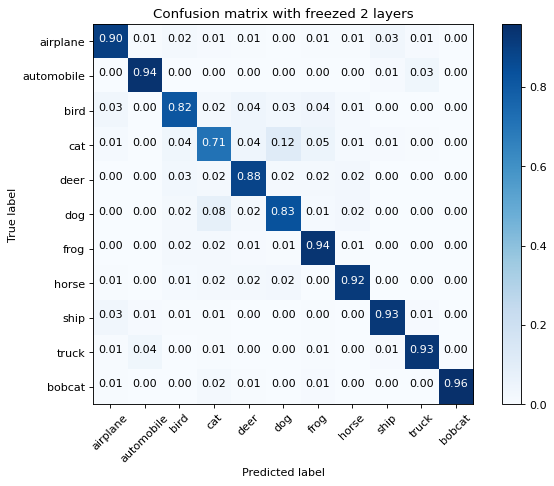

Normalized confusion matrix


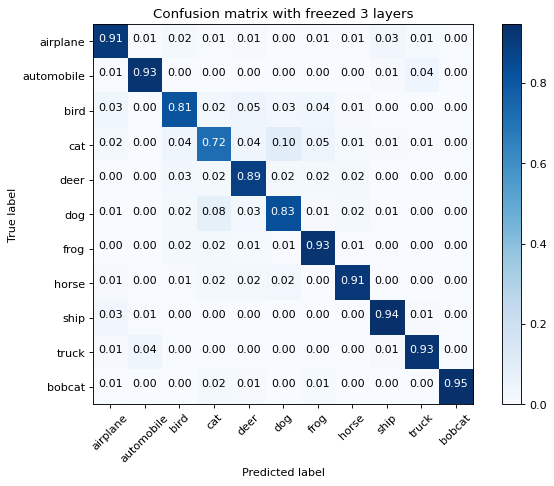

Normalized confusion matrix


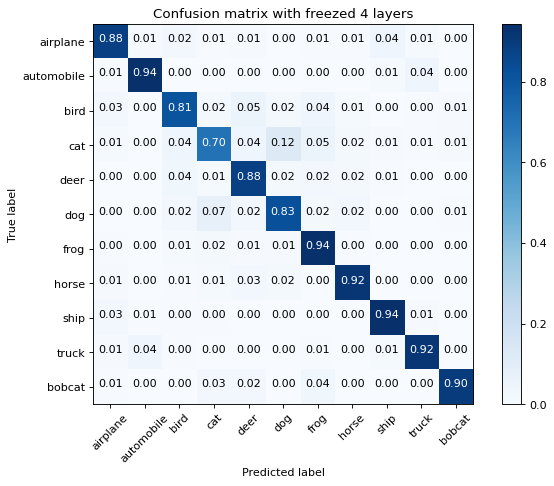

Normalized confusion matrix


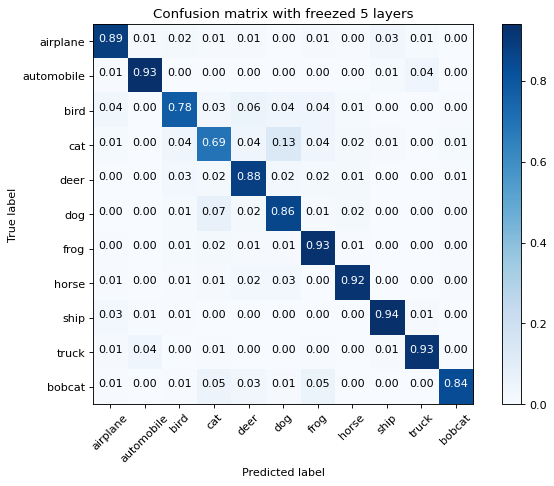

Normalized confusion matrix


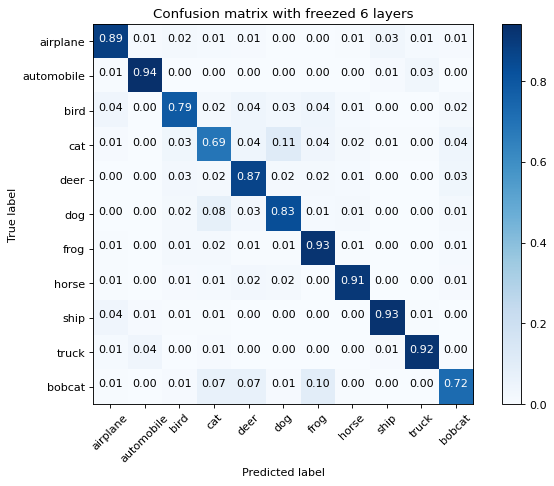

Normalized confusion matrix


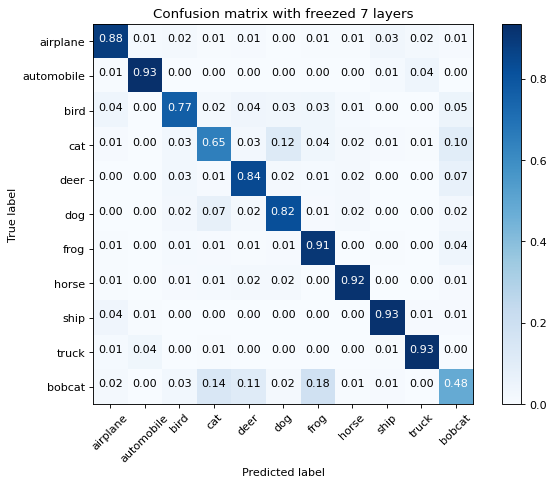

In [30]:
for i in range(7):

    file = "freezed_"+str(i)+".h5"
    new_model = keras.models.load_model(file)
    p_test = new_model.predict(x_test).argmax(axis=1)
    cm = confusion_matrix(y_test, p_test)
    plt.figure(figsize=(8, 6), dpi=80)
    plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True,title='Confusion matrix with freezed '+str(i+1)+" layers")

### 5.2 Unfreezed Model

Normalized confusion matrix


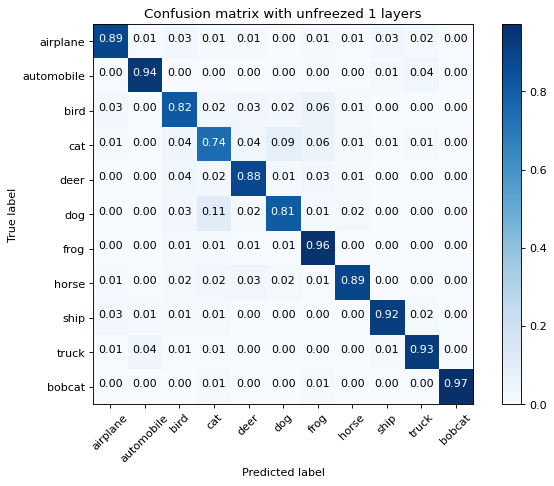

Normalized confusion matrix


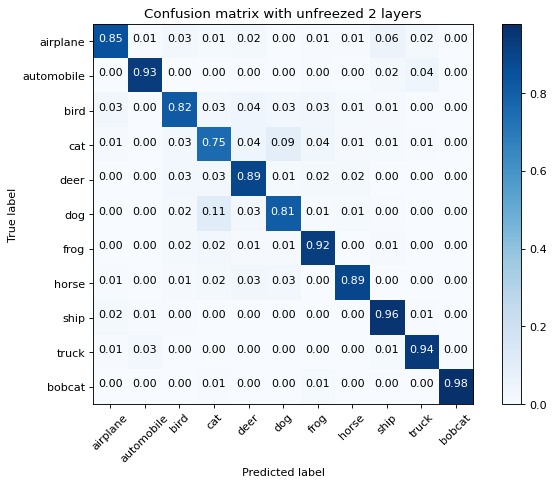

Normalized confusion matrix


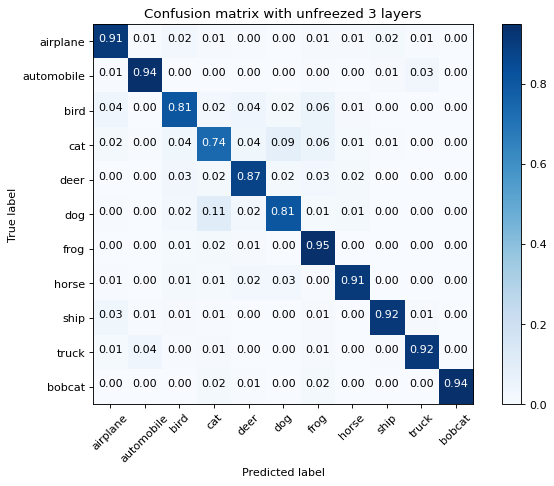

Normalized confusion matrix


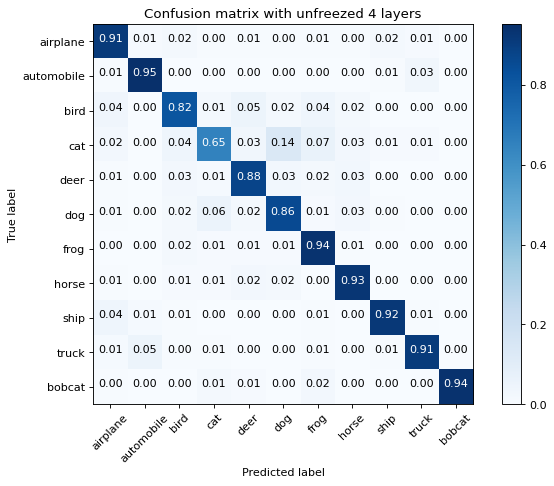

Normalized confusion matrix


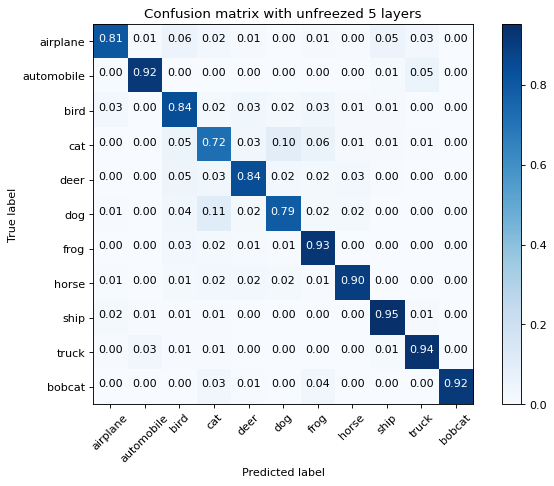

Normalized confusion matrix


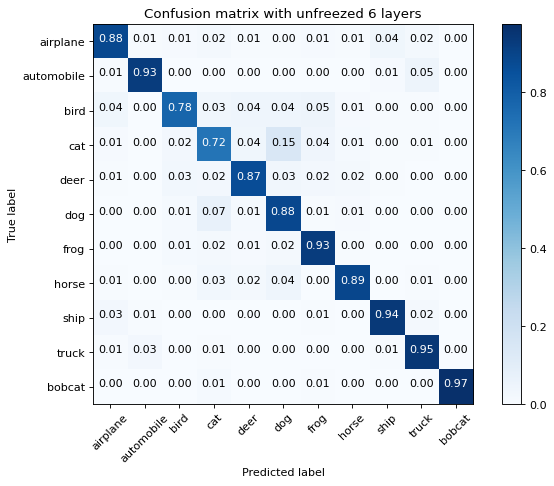

Normalized confusion matrix


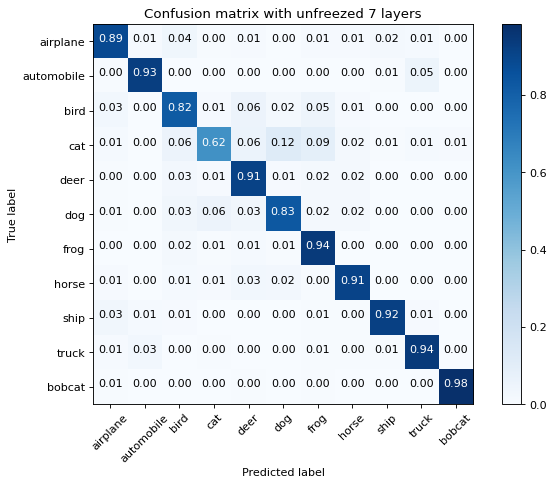

In [35]:
for i in range(7):
    file = 'unfreezed_'+str(i)+'.h5'
    new_model = keras.models.load_model(file)
    p_test = new_model.predict(x_test).argmax(axis=1)
    cm = confusion_matrix(y_test, p_test)
    plt.figure(figsize=(8, 6), dpi=80)
    plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True,title='Confusion matrix with unfreezed '+str(i+1)+" layers")

## 6. Plot Accuracies
### 6.1 Overall Accuracy

344/344 [==============================] - 7s 19ms/step - loss: 0.4428 - accuracy: 0.8806


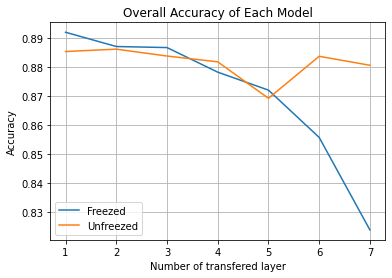

In [36]:
acc_fz =[]
acc_unfz =[]
x =[1,2,3,4,5,6,7]
for i in range(7):
    file = 'freezed_'+str(i)+'.h5'
    new_model = keras.models.load_model(file)
    evaluation = new_model.evaluate(x_test, y_test_cat)
    acc_fz.append(evaluation[1])
    
    file = 'unfreezed_'+str(i)+'.h5'
    new_model = keras.models.load_model(file)
    evaluation = new_model.evaluate(x_test, y_test_cat)
    acc_unfz.append(evaluation[1])

plt.plot(x,acc_fz,x,acc_unfz)
plt.grid()
plt.title("Overall Accuracy of Each Model")
plt.xlabel("Number of transfered layer")
plt.ylabel("Accuracy")
plt.legend(["Freezed","Unfreezed"])

The overall accuracy of the unfreezed learn is between 0.86 to 0.98 which is same as the result indicated by the paper `NIPS-2014-how-transferable-are-features-in-deep-neural-networks-Paper`. 

The accuracy of freezed learn drops continuously as the number of transfered layers increases which was expected to increase after transferring 6 and 7 layers, the reason might be that the dataset is too small to make the overall accuracy come back.

### 6.2 Cat Detection Accuracy

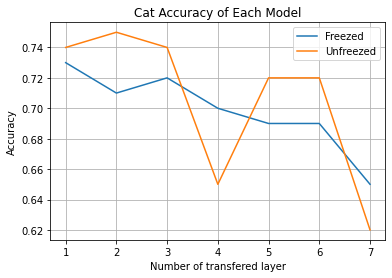

In [40]:
# from confusion matrix
x =[1,2,3,4,5,6,7]
fz_accuracy = [0.73,0.71,0.72,0.70,0.69,0.69,0.65]
unfz_accuracy = [0.74,0.75,0.74,0.65,0.72,0.72,0.62]

plt.plot(x,fz_accuracy,x,unfz_accuracy)
plt.grid()
plt.title("Cat Accuracy of Each Model")
plt.xlabel("Number of transfered layer")
plt.ylabel("Accuracy")
plt.legend(["Freezed","Unfreezed"])

Both freezed learning's and unfreezed learning's cat accuracy drops down as number of transferred layer increases. The reason might be that bobcat and cat image are similar and the model needs more epochs to converge.

### 6.3 Bobcat Detection Accuracy

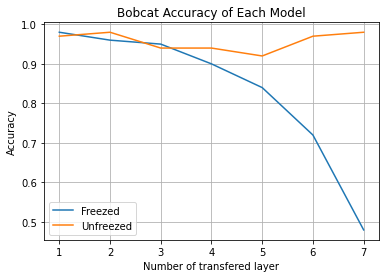

In [39]:
# from confusion matrix
x =[1,2,3,4,5,6,7]
fz_accuracy = [0.98,0.96,0.95,0.9,0.84,0.72,0.48]
unfz_accuracy = [0.97,0.98,0.94,0.94,0.92,0.97,0.98]

plt.plot(x,fz_accuracy,x,unfz_accuracy)
plt.grid()
plt.title("Bobcat Accuracy of Each Model")
plt.xlabel("Number of transfered layer")
plt.ylabel("Accuracy")
plt.legend(["Freezed","Unfreezed"])

The bobcat accuracy for unfreezed training is generally above 90% and is similar transferring different number of layers. The reason of this result is that all weight is trainable so the model can converge faster with the transferred weight without affecting accuracy.  

The bobcat accuracy for freezed training drops down as number of transferred layers increases. The reason is that fewer weight can be trained as the number of transferred layers increases to recognize a new class added to the model.

## 7. Training With ResNet

In [61]:
from tensorflow.keras.applications import ResNet50V2
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

model = ResNet50V2(input_shape=(32,32,3), classes=11, weights=None, include_top=False)
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(11, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_30[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 18, 18, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [63]:
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train,y_train_cat,epochs=10,validation_data=(x_test,y_test_cat))

Epoch 1/10
1719/1719 [==============================] - 832s 483ms/step - loss: 1.7563 - accuracy: 0.3635 - val_loss: 2.5654 - val_accuracy: 0.3482
Epoch 2/10
1719/1719 [==============================] - 717s 417ms/step - loss: 1.4332 - accuracy: 0.4977 - val_loss: 1.5183 - val_accuracy: 0.4715
Epoch 3/10
1719/1719 [==============================] - 759s 441ms/step - loss: 1.2472 - accuracy: 0.5693 - val_loss: 1.8751 - val_accuracy: 0.3681
Epoch 4/10
1719/1719 [==============================] - 890s 518ms/step - loss: 1.1237 - accuracy: 0.6142 - val_loss: 1.2902 - val_accuracy: 0.5606
Epoch 5/10
1719/1719 [==============================] - 831s 484ms/step - loss: 0.9570 - accuracy: 0.6755 - val_loss: 1.3347 - val_accuracy: 0.5628
Epoch 6/10
1719/1719 [==============================] - 821s 478ms/step - loss: 0.8555 - accuracy: 0.7107 - val_loss: 1.3954 - val_accuracy: 0.5721
Epoch 7/10
1719/1719 [==============================] - 666s 388ms/step - loss: 0.7535 - accuracy: 0.7439 - val_

In [67]:
model.fit(x_train,y_train_cat,epochs=10,validation_data=(x_test,y_test_cat))

Epoch 1/10
1719/1719 [==============================] - 667s 388ms/step - loss: 0.4572 - accuracy: 0.8452 - val_loss: 0.9054 - val_accuracy: 0.7188
Epoch 2/10
1719/1719 [==============================] - 678s 394ms/step - loss: 0.3975 - accuracy: 0.8643 - val_loss: 0.9315 - val_accuracy: 0.7183
Epoch 3/10
1719/1719 [==============================] - 705s 410ms/step - loss: 0.3517 - accuracy: 0.8812 - val_loss: 1.6406 - val_accuracy: 0.5516
Epoch 4/10
1719/1719 [==============================] - 689s 401ms/step - loss: 0.3126 - accuracy: 0.8946 - val_loss: 1.0839 - val_accuracy: 0.6987
Epoch 5/10
1719/1719 [==============================] - 764s 445ms/step - loss: 0.2730 - accuracy: 0.9075 - val_loss: 0.9161 - val_accuracy: 0.7398
Epoch 6/10
1719/1719 [==============================] - 1085s 632ms/step - loss: 0.3383 - accuracy: 0.8867 - val_loss: 1.0323 - val_accuracy: 0.7066
Epoch 7/10
1719/1719 [==============================] - 712s 414ms/step - loss: 0.2232 - accuracy: 0.9257 - val

In [68]:
model.save("resnet_tf.h5")

Normalized confusion matrix


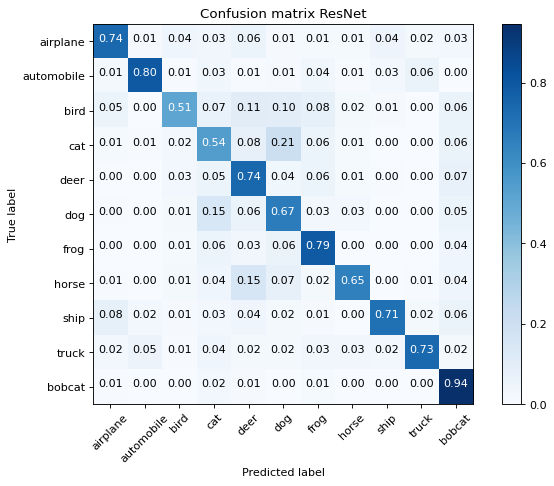

In [77]:
import keras

file = "resnet_tf.h5"
model = keras.models.load_model(file)
p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plt.figure(figsize=(8, 6), dpi=80)
plot_confusion_matrix(cm , ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck','bobcat'],normalize=True,title="Confusion matrix ResNet")

After training 20 epoch with ResNet50V2 the training accuracy reaches to 94% and the validation accuracy is 71%. The difference between training and validation accuracy might indicate overfitting, but the model have a 94% accuracy when predicting Bobcat which is desirable